In [1]:
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

In [2]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    df.drop(columns=['floor', 'expenses'], inplace=True)
    df.drop(columns=['price','price_aprox_local_currency','price_per_m2','price_usd_per_m2',], inplace=True)
    df.drop(columns=['rooms', 'surface_total_in_m2'], inplace=True)
    df.drop(columns=['operation', 'property_type', 'currency', 'properati_url'], inplace=True)
    
    return df

In [3]:
files = glob('./buenos-aires-real-estate-*.csv')
files

['.\\buenos-aires-real-estate-1.csv', '.\\buenos-aires-real-estate-2.csv']

In [4]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [5]:
df = pd.concat(frames, ignore_index=True)

In [6]:
#sorted(df.columns)  #remove leakage columns

In [7]:
#df.isnull().sum() / len(df)

<Axes: >

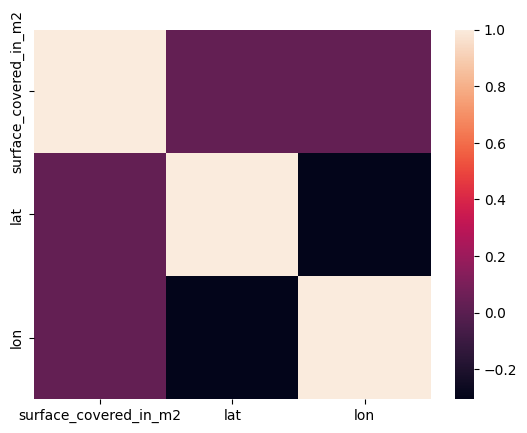

In [8]:
corr = df.select_dtypes('number').drop(columns=['price_aprox_usd']).corr()
sns.heatmap(corr)

In [9]:
df.select_dtypes('object').nunique()

neighborhood    54
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        2658 non-null   float64
 1   surface_covered_in_m2  2658 non-null   float64
 2   lat                    2561 non-null   float64
 3   lon                    2561 non-null   float64
 4   neighborhood           2658 non-null   object 
dtypes: float64(4), object(1)
memory usage: 104.0+ KB


In [11]:
features = ['surface_covered_in_m2', 'lat', 'lon', 'neighborhood']
target = 'price_aprox_usd'
X_train = df[features]
y_train = df[target] 

In [12]:
#build a baseline model
mean = y_train.mean()
y_pred_baseline = [mean] * len(y_train)
mae = mean_absolute_error(y_pred_baseline, y_train)
mae

45422.75166805662

In [13]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [14]:
y_pred_training = model.predict(X_train)
new_mae = mean_absolute_error(y_pred_training, y_train)
new_mae

24638.87398345607

In [15]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        'surface_covered_in_m2': area,
        'lat': lat, 
        'lon': lon,
        'neighborhood': neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df)[0]
    return f"Predicted apartment price: ${prediction}"

In [16]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $254105.9704060834'

In [ ]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=54, description='area', min=31), FloatSlider(value=-34.598285911342714, …

In [18]:
import joblib

In [19]:
joblib.dump(model, 'model.pkl')

['model.pkl']

In [20]:
df.to_csv('combined_dataset_buenos_aires.csv', index=False)